In [4]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split

nlp = spacy.load("en_core_web_sm")
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.remove('up')
stopword_list.remove('down')

In [5]:
df = pd.read_csv('./data/all-data.csv', names = ['labels','messages'],encoding='ISO-8859-1')

In [6]:
df.head()

,labels,messages
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


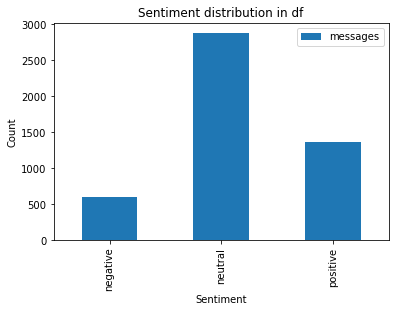

In [7]:
df.groupby(['labels']).count().plot.bar()
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.title("Sentiment distribution in df")
plt.show()

In [8]:
### remove stopwords

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [9]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

In [10]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("Returning books is something I remain thinking about") #odd sentence, I know

'return book be something I remain think about'

In [11]:
def normalize_text(text):
    exp = expand_contractions(text)
    low = exp.lower()
    lemm = lemmatize_text(low)
    no_sw = remove_stopwords(lemm)
    return simple_preprocess(no_sw)

In [12]:
#### text preprocess:

df['messages'] = [normalize_text(row) for row in df['messages']]

In [13]:
df.iloc[0]['messages'][:3]

['accord', 'gran', 'company']

In [14]:
### map sentiment to int:

def map_sentiment(sentiment):
    if sentiment == 'negative':
        return -1
    elif sentiment == 'neutral':
        return 0
    else:
        return 1

In [15]:
df['labels'] = [map_sentiment(row) for row in df['labels']]

In [16]:
df['labels'].head(3)

0    0
1    0
2   -1
Name: labels, dtype: int64

Number of rows per sentiment:
 0    2879
 1    1363
-1     604
Name: labels, dtype: int64


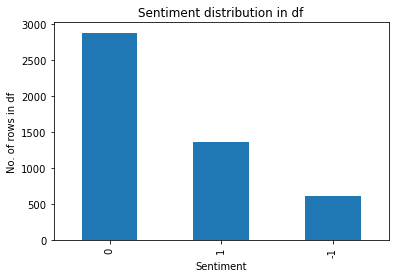

In [17]:
print("Number of rows per sentiment:")
print(df['labels'].value_counts())

plt.figure()
pd.value_counts(df['labels']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [18]:
# Train-Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True, ):
    X_train, X_test, Y_train, Y_test = train_test_split(df['messages'], 
                                                        df['labels'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
 0    2000
 1     956
-1     436
Name: labels, dtype: int64
Value counts for Test sentiments
 0    879
 1    407
-1    168
Name: labels, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
   index                                           messages
0   2988  [market, share, percent, accord, ac, nielsen, ...
1   3236                   [ecb, mainly, target, inflation]
2   2061  [scania, morgan, stanley, lift, share, target,...
3   3002  [kirsi, rantanen, previously, development, dir...
4   1417  [russian, government, contribute, necessary, f...


In [20]:
from gensim.models import Word2Vec
import time

# Skip-gram model (sg = 1)
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

word2vec_model_file = './data' + 'word2vec_' + str(size) + '.model'
start_time = time.time()
lemmed_tokens = pd.Series(df['messages']).values
# Train the Word2Vec Model
w2v_model = Word2Vec(lemmed_tokens, min_count = min_count, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 0.42572903633117676


In [21]:
import numpy as np
# Load the model from the model file
sg_w2v_model = Word2Vec.load(word2vec_model_file)

In [22]:
# Get vector form of word "asset"
sg_w2v_model.wv.get_vector("asset")

array([-1.87216774e-01,  1.22882850e-01,  3.63118835e-02, -5.54206707e-02,
        2.55432297e-02, -3.76237184e-01,  1.44346237e-01,  3.79455954e-01,
       -1.29917413e-01, -1.42546654e-01, -1.62996203e-01, -2.53621995e-01,
       -1.45100147e-01,  1.06877446e-01,  7.92294834e-03, -1.72047094e-01,
        8.44311044e-02, -2.32013509e-01,  7.35001490e-02, -5.26592374e-01,
        2.19251551e-02,  1.23772904e-01,  7.71209598e-02, -1.78951249e-01,
       -4.00242135e-02, -1.01121746e-01, -1.44807786e-01, -1.42811745e-01,
       -2.45484084e-01, -1.29316553e-01,  4.28558916e-01, -1.82687920e-02,
        4.00162674e-02, -1.59506902e-01,  4.26374823e-02,  1.33675292e-01,
        5.65937161e-02, -1.79648191e-01, -1.06034510e-01, -3.54548156e-01,
        7.84757547e-03, -2.35408679e-01,  2.25605909e-03, -1.02657769e-02,
        1.22405894e-01, -1.22147210e-01, -9.91949439e-02, -9.94477272e-02,
        1.09271705e-01,  1.62054881e-01,  1.98277831e-01, -1.42779768e-01,
        9.06228262e-04, -

In [23]:
# Get shape of vector "asset"
print("Shape of the vector: ", sg_w2v_model.wv.get_vector('asset').shape)

Shape of the vector:  (100,)


In [25]:
# Similarity and distance between [buy, up] and [sell, down]
sg_w2v_model.wv.n_similarity(["buy", "up"], ["sell", "down"])

0.9905195

In [26]:
# Distance between "buy" and "sell"
sg_w2v_model.wv.distance("buy", "sell")

0.022113442420959473

In [27]:
# Similar word for buy:
sg_w2v_model.wv.similar_by_word("buy")

[('okmetic', 0.9980117082595825),
 ('tikkurila', 0.9978948831558228),
 ('metso', 0.9978446364402771),
 ('cencorp', 0.9976803064346313),
 ('yit', 0.997469425201416),
 ('outotec', 0.9972758293151855),
 ('outokumpu', 0.9972071647644043),
 ('kemira', 0.9971125721931458),
 ('konecrane', 0.9970983266830444),
 ('corp', 0.9969936609268188)]

In [28]:
# Similar word for sell:
sg_w2v_model.wv.similar_by_word("sell")

[('hold', 0.9974731206893921),
 ('stake', 0.9964633584022522),
 ('acquire', 0.9951412081718445),
 ('maximum', 0.9950560927391052),
 ('vote', 0.9946046471595764),
 ('outstanding', 0.9944924712181091),
 ('bond', 0.9938133955001831),
 ('close', 0.993483304977417),
 ('would', 0.9933252930641174),
 ('propose', 0.9930647611618042)]

In [31]:
X_train.head(3)

,index,messages
0,2988,"[market, share, percent, accord, ac, nielsen, ..."
1,3236,"[ecb, mainly, target, inflation]"
2,2061,"[scania, morgan, stanley, lift, share, target,..."


In [37]:
# Store the vectors for train data in following file
word2vec_filename = './data' + 'train_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        model_vector = (np.mean([i for i in sg_w2v_model.wv.vectors], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

In [38]:
train_data = pd.read_csv('datatrain_review_word2vec.csv')

In [48]:
train_data.iloc[:3, 3]

0   -0.018542
1   -0.018542
2   -0.018542
Name: 3, dtype: float64

In [49]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(sg_w2v_model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)

/Users/kevinkwasnik/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kevinkwasnik/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
